# Machine Learning Worflow

The stages and workflows that are involved in Machine Learning projects are evolving as the field and technology itself develops. But there are standard steps that you should follow for a data science project.

![title](./images/ml_workflow.png)

# Defining The Problem and Proposing A Solution
## Calculating the Probability of Future Customer Engagement
In non-subscription retail models, customers come and go with no long-term commitments, making it very difficult to determine whether a customer will return in the future. Determining the probability that a customer will re-engage is critical to the design of effective marketing campaigns. Different messaging and promotions may be required to incentivize customers who have likely dropped out to return to our stores. Engaged customers may be more responsive to marketing that encourages them to expand the breadth and scale of purchases with us. Understanding where our customers land with regard to the probability of future engagement is critical to tailoring our marketing efforts to them.

The *Buy til You Die (BTYD)* models popularized by Peter Fader and others leverage two basic customer metrics, i.e. the recency of a customer's last engagement and the frequency of repeat transactions over a customer's lifetime, to derive a probability of future re-engagement. This is done by fitting customer history to curves describing the distribution of purchase frequencies and engagement drop-off following a prior purchase. The math behind these models is fairly complex but thankfully it's been encapsulated in the lifetimes library, making it much easier for traditional enterprises to employ. The purpose of this notebook is to examine how these models may be applied to customer transaction history and how they may be deployed for integration in marketing processes.

# Construct the dataset and Transform data

### Importing required packages and read the prepared data

In [1]:
import pandas as pd
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_palette('coolwarm')
sns.set(rc= {'image.cmap': 'coolwarm'})
rcParams['figure.figsize'] = 11.7,8.27
sns.set(rc={'figure.figsize':(11.7,8.27)})


# Loading the dataset
df= pd.read_csv("data/deposits.csv")
df.head()

,transaction_id,transaction_time,user_id,amount_usd
0,11000,12/1/10 8:26,17850.0,15.30
1,11001,12/1/10 8:26,17850.0,20.34
2,11002,12/1/10 8:26,17850.0,22.00
3,11003,12/1/10 8:26,17850.0,20.34
4,11004,12/1/10 8:26,17850.0,20.34


In [2]:
# checking the shape of the data
df.shape

(541909, 4)

### Set date to datetime format

In [3]:
import datetime as dt
df['transaction_time'] =  pd.to_datetime(df['transaction_time'])
df['transaction_date'] =  pd.to_datetime(df['transaction_time']).dt.date
df.head()

,transaction_id,transaction_time,user_id,amount_usd,transaction_date
0,11000,2010-12-01 08:26:00,17850.0,15.30,2010-12-01
1,11001,2010-12-01 08:26:00,17850.0,20.34,2010-12-01
2,11002,2010-12-01 08:26:00,17850.0,22.00,2010-12-01
3,11003,2010-12-01 08:26:00,17850.0,20.34,2010-12-01
4,11004,2010-12-01 08:26:00,17850.0,20.34,2010-12-01


### Explore the Dataset

Checking transaction activity in the dataset. The daily transaction count shows there is quite a bit of volatility in daily activity of our customers.

<AxesSubplot:xlabel='transaction_date'>

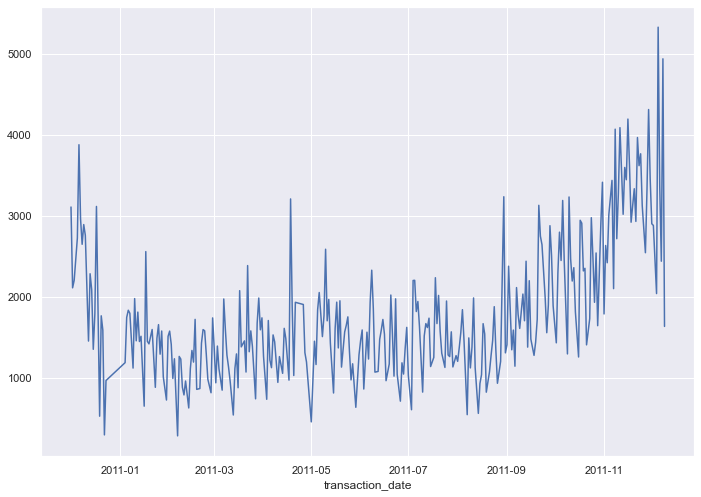

In [4]:
df.groupby('transaction_date').transaction_id.nunique().plot()

Let's smooth this chart out by summarizing it by month.

<AxesSubplot:xlabel='transaction_time'>

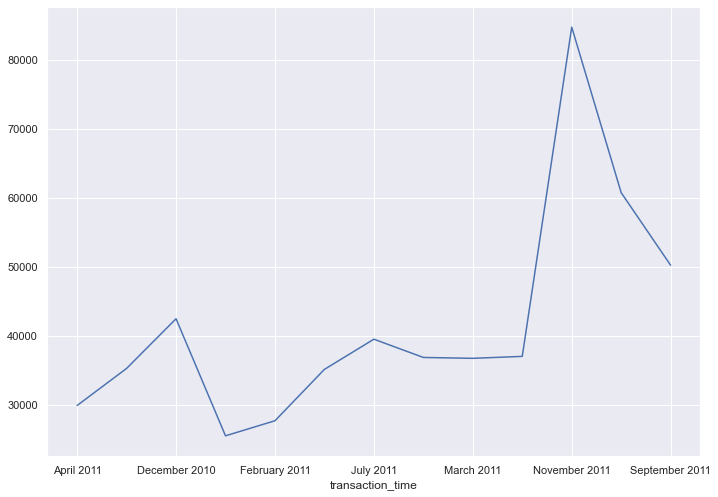

In [6]:
df.groupby(df['transaction_time'].dt.strftime('%B %Y')).transaction_id.nunique().plot()

How many customers was engaged with the company and how many transactions was accompolished during the date range.

In [8]:
print(df['user_id'].nunique())
print(df['transaction_id'].nunique())

4372
541909


let's count unique transactions by customer and then plot the frequncy of these values. As you can see many of customers just did one sigle transaction.

The distribution of the count of repeat purchases declines from there in a manner that we may describe as negative binomial distribution (which is the basis of the NBD acronym included in the name of most BTYD models)

<AxesSubplot:ylabel='Frequency'>

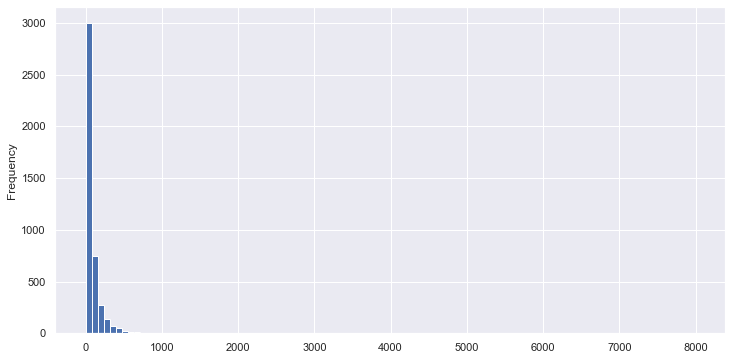

In [9]:
df.groupby('user_id').agg(
    occurrenece=('transaction_id','nunique')
    ).reset_index()['occurrenece'].plot(kind='hist',bins=100,color='b',figsize=(12,6))

If we alter our last analysis to group a customer's transactions that occur on the same date into a single transaction - a pattern that aligns with metrics we will calculate later - we see that a few more customers are identified as non-repeat customers but the overall pattern remains the same:

<AxesSubplot:ylabel='Frequency'>

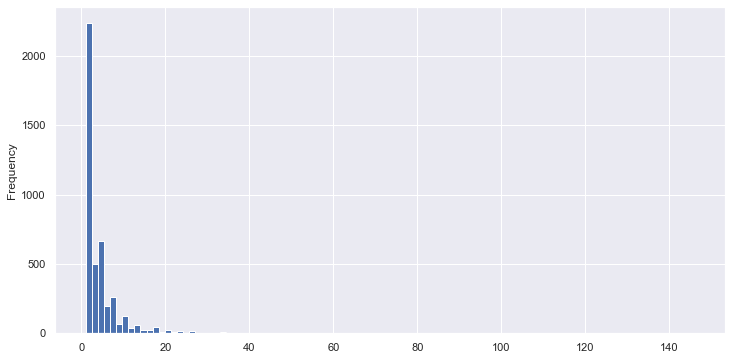

In [11]:
df.groupby(['user_id']).agg(
    occurrence=('transaction_date','nunique')
    ).reset_index()['occurrence'].plot(kind='hist',bins=100,color='b',figsize=(12,6))

Focusing on customers with repeat purchases, we can examine the distribution of the days between purchase events. What's important to note here is that most customers return to the site within 2 to 3 months of a prior purchase. Longer gaps do occur but significantly fewer customers have longer gaps between returns. This is important to understand in the context of our BYTD models in that the time since we last saw a customer is a critical factor to determining whether they will ever come back with the probability of return dropping as more and more time passes since a customer's last purchase event:

In [12]:
df_dist=df[['user_id','transaction_date']].drop_duplicates()

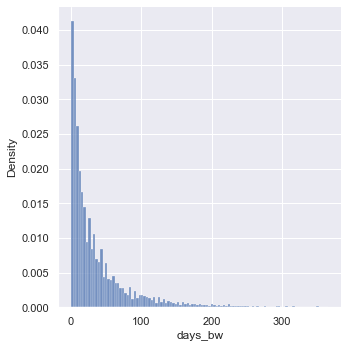

In [14]:
df_dist['previous_transaction'] = df_dist.groupby(['user_id'])['transaction_date'].shift()
df_dist['days_bw'] = df['transaction_date'] - df_dist['previous_transaction']
df_dist['days_bw'] = df_dist['days_bw'].apply(lambda x: x.days)
sns.displot(x=df_dist['days_bw'],stat='density')

## 3. Importing lifetimes package to view our data into RFM metrics

The dataset with which we are working consists of raw transactional history. To apply the BTYD models, we need to derive several per-customer metrics:

`frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

`monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

To calculate these metrics there are built-in functions in liftimes library.

In [15]:
import lifetimes
current_date=df['transaction_date'].max()
metrics_df = lifetimes.utils.summary_data_from_transaction_data(df, 'user_id','transaction_date', monetary_value_col = 'amount_usd', observation_period_end = current_date)
metrics_df.head(10)

,frequency,recency,T,monetary_value
user_id,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
12352.0,6.0,260.0,296.0,208.151667
12353.0,0.0,0.0,204.0,0.000000
12354.0,0.0,0.0,232.0,0.000000
12355.0,0.0,0.0,214.0,0.000000


In [16]:
metrics_df.describe()

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209,213.254316
std,6.674343,133.000474,118.384168,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538


# 4. Train-Test Split

The train-test split is a technique for evaluating the performance of a machine learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

`Train Dataset`: Used to fit the machine learning model.
`Test Dataset` : Used to evaluate the fit machine learning model.

![image info](./images/train-test.png)

In [17]:
holdout_days = 90
calibration_end_date= current_date - dt.timedelta(days=holdout_days)
metrics_cal_df=lifetimes.utils.calibration_and_holdout_data(
    df,
    customer_id_col='user_id',
    datetime_col='transaction_date',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D'    
)
metrics_cal_df.head(10)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
12346.0,0.0,0.0,235.0,0.0,90.0
12347.0,4.0,238.0,277.0,2.0,90.0
12348.0,2.0,110.0,268.0,1.0,90.0
12350.0,0.0,0.0,220.0,0.0,90.0
12352.0,3.0,34.0,206.0,3.0,90.0
12353.0,0.0,0.0,114.0,0.0,90.0
12354.0,0.0,0.0,142.0,0.0,90.0
12355.0,0.0,0.0,124.0,0.0,90.0
12356.0,1.0,80.0,235.0,1.0,90.0


In [18]:
metrics_cal_df.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587046,185.041618,1.502345,90.0
std,5.222838,96.077761,80.771943,2.495318,0.0
min,0.000000,0.000000,1.000000,0.000000,90.0
25%,0.000000,0.000000,125.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,1.000000,90.0
75%,3.000000,175.000000,268.000000,2.000000,90.0
max,93.000000,282.000000,283.000000,52.000000,90.0


In [19]:
# remove customers with no repeats (complete dataset)
filtered_df = metrics_df[metrics_df['frequency'] > 0]

## remove customers with no repeats in calibration period
filtered_cal_df = metrics_cal_df[metrics_cal_df['frequency_cal'] > 0]

## 6. Fitting the model

In [20]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(filtered_cal_df['frequency_cal'],filtered_cal_df['recency_cal'],filtered_cal_df['T_cal'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 2163 subjects, a: 0.09, alpha: 95.54, b: 0.55, r: 2.28>


,coef,se(coef),lower 95% bound,upper 95% bound
r,2.275392,0.103232,2.073058,2.477726
alpha,95.542878,4.737910,86.256574,104.829182
a,0.093539,0.015787,0.062596,0.124482
b,0.547570,0.105325,0.341133,0.754007


In [21]:
frequency_holdout_predicted = bgf.predict(
    filtered_cal_df['duration_holdout'],
    filtered_cal_df['frequency_cal'],
    filtered_cal_df['recency_cal'],
    filtered_cal_df['T_cal'])

In [22]:
frequency_holdout_actual = filtered_cal_df['frequency_holdout']

In [23]:
import numpy as np

def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# score the model
print('MSE: {0}'.format(score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')))

MSE: 4.027424975706059


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

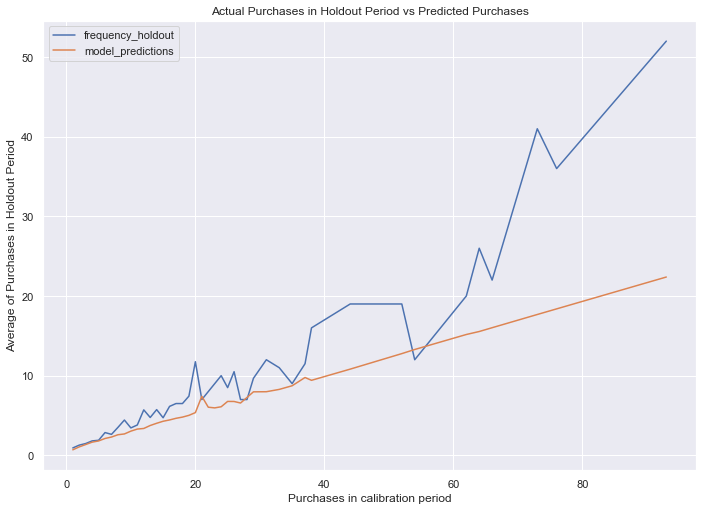

In [24]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(
  bgf, 
  filtered_cal_df, 
  n=90, 
  )

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Time since user made last purchase', ylabel='Average of Purchases in Holdout Period'>

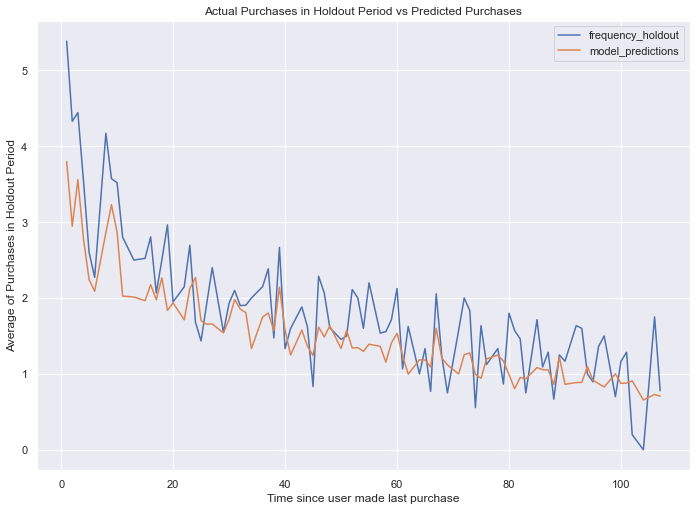

In [25]:
plot_calibration_purchases_vs_holdout_purchases(
  bgf, 
  filtered_cal_df,
  kind='time_since_last_purchase', 
  n=90, 
  )

In [26]:
filtered_df['prob_alive']=bgf.conditional_probability_alive(
    filtered_df['frequency'], 
    filtered_df['recency'], 
    filtered_df['T']
    )

filtered_df.head(10)

,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.982823
12348.0,3.0,283.0,358.0,301.480000,0.913008
12352.0,6.0,260.0,296.0,208.151667,0.963896
12356.0,2.0,303.0,325.0,269.905000,0.929323
12358.0,1.0,149.0,150.0,683.200000,0.852424
12359.0,5.0,324.0,331.0,1139.606000,0.977326
12360.0,2.0,148.0,200.0,789.240000,0.878541
12362.0,12.0,292.0,295.0,389.623333,0.991038
12363.0,1.0,133.0,242.0,252.900000,0.620062


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

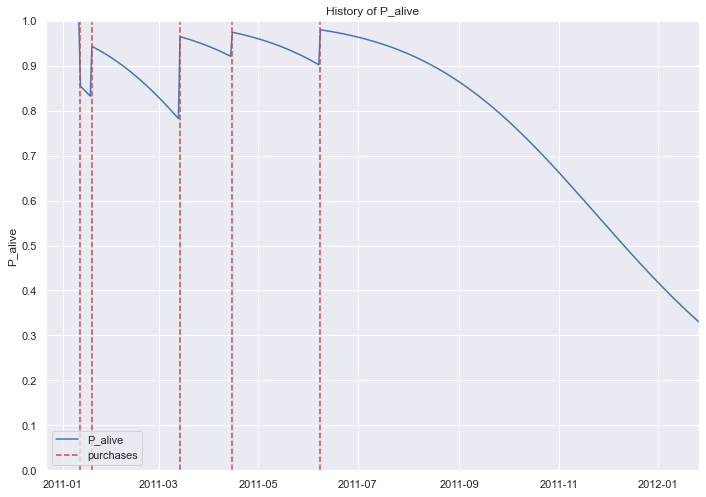

In [27]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

# clear past visualization instructions
plt.clf()

# customer of interest
CustomerID = 12383

# grab customer's metrics and transaction history
filtered_cal_df=filtered_cal_df.reset_index()
cmetrics_pd = filtered_cal_df[filtered_cal_df['user_id']==CustomerID]
trans_history = df.loc[df['user_id'] == CustomerID]

# calculate age at end of dataset
days_since_birth = 400

# plot history of being "alive"
plot_history_alive(
  bgf, 
  days_since_birth, 
  trans_history, 
  'transaction_date'
  )

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

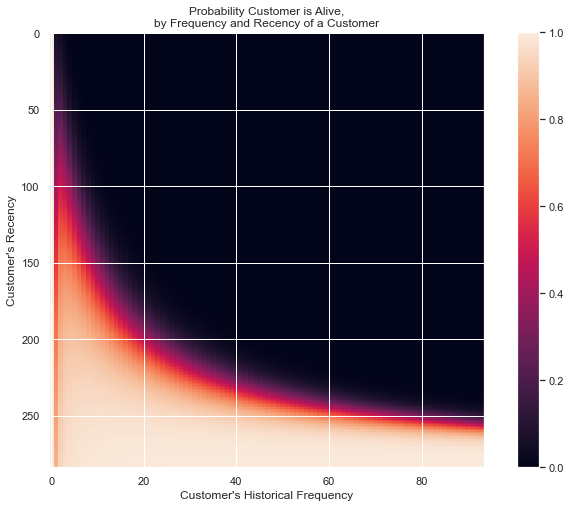

In [28]:
from lifetimes.plotting import plot_probability_alive_matrix

# set figure size
plt.subplots(figsize=(12, 8))

plot_probability_alive_matrix(bgf)


## 7. Visualizing the frequency/recency metrics

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

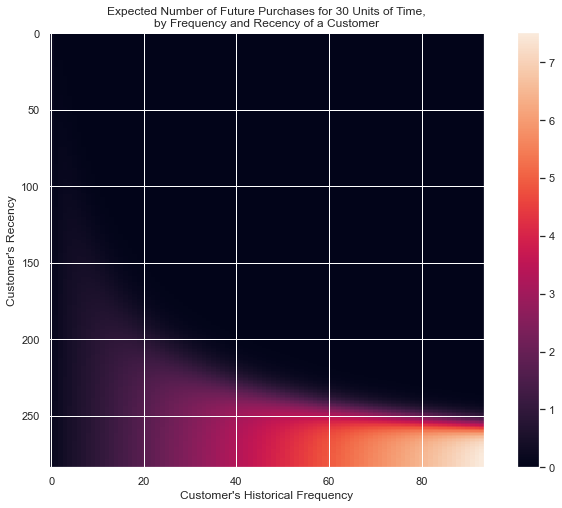

In [29]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf,T=30)

## 9. Predict expected deposit and rank the client in the next period

In [30]:
filtered_df['purchases_next30days']=(
  bgf.conditional_expected_number_of_purchases_up_to_time(
    30, 
    filtered_df['frequency'], 
    filtered_df['recency'], 
    filtered_df['T']
    )
  )

filtered_df.head(10)

,frequency,recency,T,monetary_value,prob_alive,purchases_next30days
user_id,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.982823,0.525346
12348.0,3.0,283.0,358.0,301.480000,0.913008,0.316953
12352.0,6.0,260.0,296.0,208.151667,0.963896,0.608219
12356.0,2.0,303.0,325.0,269.905000,0.929323,0.281626
12358.0,1.0,149.0,150.0,683.200000,0.852424,0.336454
12359.0,5.0,324.0,331.0,1139.606000,0.977326,0.497766
12360.0,2.0,148.0,200.0,789.240000,0.878541,0.377873
12362.0,12.0,292.0,295.0,389.623333,0.991038,1.082186
12363.0,1.0,133.0,242.0,252.900000,0.620062,0.178668


In [31]:
filtered_df.sort_values(by = 'purchases_next30days').tail(5)

,frequency,recency,T,monetary_value,prob_alive,purchases_next30days
user_id,,,,,,
14606.0,88.0,372.0,373.0,130.858295,0.998706,5.755312
15311.0,90.0,373.0,373.0,655.266778,0.998957,5.884305
17841.0,112.0,372.0,373.0,355.421429,0.998931,7.287152
12748.0,114.0,373.0,373.0,254.975000,0.999177,7.416525
14911.0,145.0,372.0,373.0,910.463724,0.999114,9.393377


## 10. Assessing model fit

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

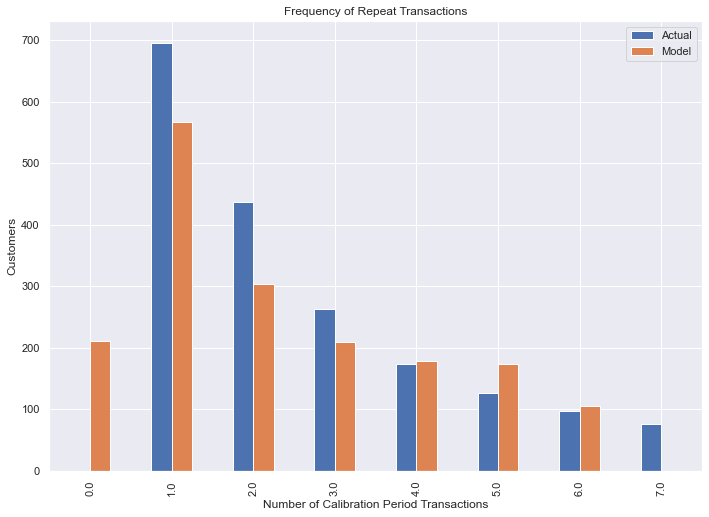

In [32]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [33]:
from lifetimes import GammaGammaFitter

clv_df = metrics_df[(metrics_df['frequency']>0) & (metrics_df['monetary_value']>0)]
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(clv_df['frequency'],
        clv_df['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2796 subjects, p: 1.60, q: 3.59, v: 553.51>


We can now estimate the average transaction value:

In [41]:
expected_deposit = ggf.conditional_expected_average_profit(
        clv_df['frequency'],
        clv_df['monetary_value']
    )


In [43]:
expected_deposit.head(10)

user_id
12347.0    544.801062
12348.0    315.531270
12352.0    236.518746
12356.0    301.970378
12358.0    471.915541
12359.0    944.253705
12360.0    588.847272
12362.0    383.902541
12363.0    307.717271
12364.0    268.944370
dtype: float64

In [47]:
print("Expected conditional average profit: %s, Average profit: %s" % 
( expected_deposit.mean() , clv_df[clv_df['frequency'] > 0]['monetary_value'].mean())
)

Expected conditional average profit: 348.4762177527137, Average profit: 339.2490770584033


In [49]:
ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    metrics_df['frequency'],
    metrics_df['recency'],
    metrics_df['T'],
    metrics_df['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

user_id
12346.0            NaN
12347.0    3114.046005
12348.0    1080.715540
12349.0            NaN
12350.0            NaN
              ...     
18280.0            NaN
18281.0            NaN
18282.0     974.175119
18283.0    1983.435621
18287.0    1825.894227
Name: clv, Length: 4372, dtype: float64